# Abstract

In this tutorial we introduce the "Bayes by Backprop" algorithm. It is an algorithm to make the calculation of the posterior weight distribution of neural networks tractable. The main idea of this method is to combine two standard methods, one from the Bayesian real and one from the frequentist realm:

1. Variation inference: this is a standard technique to approximate the posterior distribution in situations that are otherwise intractable. The fundamental idea is very simple: we can't do the posterior calculations (or sampling, for that matter) exactly, so we approximate the posterior with distributions we know.
2. Backpropagation (a.k.a. gradient descent): this is the default technique to optimize the weights in neural networks.

It is shown that we can use backpropagation to perform variational inference.

We use "Bayes by Backprop" on three different datasets:

1. A simulated dataset for a classification task with different Bayes rate in different regions.
2. MNIST: here we reproduce the results from the original paper and extend the method to convolutional neural networks (*at least, we try?*)
3. TBD



In [155]:
import numpy as np

from matplotlib import cm
import matplotlib.pyplot as plt

import scipy.stats
import seaborn as sns
import pandas as pd
import pymc3 as pm

from theano import shared


%matplotlib inline

# Introduction

## What are Bayesian neural networks

## Why Bayesian nets



## Problems with naive approach (sampling)

In this short section, we'll show that naive MCMC for the weights of a Bayesian Neural Network is doomed to fail. We try applying Bayesian nets to a relatively simple dataset shown below. What's interesting about this dataset is that it's easier in some regions than other.

Text(0.5, 1.0, 'Artifical dataset')

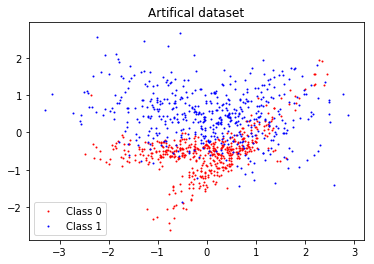

In [145]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                           class_sep=0.5, random_state=0)

plt.scatter(X[y==0, 0], X[y==0, 1], s=1, c='red', label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], s=1, c='blue', label='Class 1')
plt.legend()
plt.title("Artifical dataset")

After defining this dataset, let's try to do the classification with Bayesian neural nets. We write the model in PyMC3.

In [ ]:
n_hidden = 10

with pm.Model() as nn_simple:
    # Weights from input to hidden layer
    x = shared(X)
    w_in_h = pm.Normal('w_in_h', mu=0, sd=1, shape=(2, n_hidden))
    
    # Activations in hidden layer
    activation = pm.math.tanh(pm.math.dot(x, w_in_h))
    
    # Weights from hidden layer to output
    w_h_out = pm.Normal('w_h_out', mu=0, sd=1, shape=(n_hidden))
    logits = pm.math.dot(activation, w_h_out)
    
    # Likelihood
    obs = pm.Bernoulli('obs', logit_p=logits, observed=y)
    
    # Sampling
    trace = pm.sample(1000)
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_h_out, w_in_h]
Sampling 2 chains:  79%|███████▊  | 2359/3000 [01:38<00:25, 24.86draws/s]

We see that even this very small problem (1000 datapoints, 2 dimensions, 10 hidden units) already takes considerable time. Let's see whether it worked!

100%|██████████| 1000/1000 [00:01<00:00, 667.07it/s]


Text(0.5, 1.0, 'Posterior predictive ')

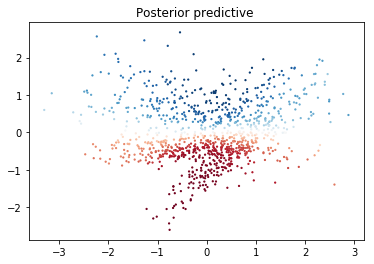

In [154]:
with nn_simple:
    ppc_samples = pm.sample_ppc(trace)
    
pred = ppc_samples['obs'].mean(axis=0)
cmap = cm.get_cmap('RdBu')
colors = [cmap(z) for z in pred]
plt.scatter(X[:, 0], X[:, 1], s=1.5, c=colors)
plt.title("Posterior predictive ")

## Solution with Variation inference

# Variational inference

In Bayesian statistics we are interested in computing the posterior probability distribution $p(\theta\vert \mathcal D)$ given some dataset $\mathcal D$. Here $\theta$ are *latent variables* like weights in a linear regression, hyperprior parameters in hierarchical models or probabilities of a datapoint belonging to a certain cluster in Gaussian Mixture models.

Computing this posterior probability is in general a **hard problem** and may or may not be tractable. There's various procedures we can use to calculate the posterior "distribution".

1. **Exact inference**: in some models, for example conjugate prior-likelihood pairs, we can calculate an exact posterior probability $p(\theta\vert \mathcal D)$. While this is the "best way" of doing inference, the challenge is that there are only a restricted number of exactly solvable models and thus our ability to model data accurately is quite restricted. Also, it usually requires detailled mathematical analysis to come up with the analytical formula.
2. **Markov Chain Monte Carlo**: this is usually the preferred way to do Bayesian inference as it allows us to draw samples and compute any quantity we are interested in arbitrarily accurately. The problem with  MCMC is that, at least [until recently](https://arxiv.org/abs/1811.02091), for high-dimensional parameter problems it has been too slow to compute samples. We'll see MCMC for neural networks failing in this tutorial.
3. **Variational inference**: this is the main technique used in this tutorial. The main idea of variational inference is to use known distribution to approximate the posterior distribution.
4. **Expecatation maximization**: EM gives a point estimate using alternating an expectation and maximization step. It is the least desired of the four methods above, as it does not give uncertainties in the latent variables.

## What is variational inference?

As described above, variational inference is a technique to use a known distribution such as a multivariate normal, to approximate the unknown posterior. What do we mean by "approximating the posterior distribution"? Denote by $p(\theta \vert \mathcal D) \propto p(\theta) p(\mathcal D \vert \theta)$ the posterior distribution, which is a function of the latent variables $\theta$. We write

$$
p(\theta \vert \mathcal D) \approx q(\theta \vert )
$$



## Easy example (maybe Gaussian and Gaussian mixture)

# Bayes by backprop

In this section, we'll see how variational inference applied to neural networks lead to the "Bayes by Backprop" algorithm if we assume a certain distribution for the weights of the neural network. This section follows very closely the [original paper](https://arxiv.org/pdf/1505.05424.pdf).

## Derivation

As we saw in the chapter on variational inference, the fundamental idea is to choose a family of distributions $q(\bf w\vert \theta)$ over the weights $\bf w$ of the neural network, parametrized by $\theta$. Then we find the parameters $\theta$ within the given family $q$ that best approximates the posterior $p(\bf w\vert \mathcal D)$, i.e. we choose the best parameters $\theta$.

It's important to note that we do not have to worry about "overfitting" when we choose the family $q$. After all, it's just approximating the posterior, so even if it has many parameters, it can't overfit.

What do we mean by "best approximation"? It's the parameter values that minimize the Kullback-Leibler divergence between $q(\bf w \vert \theta)$ and $p(\bf w\vert \mathcal D)$:

$$
\theta^* = \arg \min_{\theta} \text{KL}(q({\bf w}\vert \theta) \Vert p( {\mathbf w}\vert \mathcal D))= 
\\
= \arg \min_{\theta} \int q({\bf w} \vert \theta) \ln \frac{q( {\bf w} \vert \theta)}{p({\bf w}\vert \mathcal D)} d {\bf w} =  \\
= \arg \min_{\theta} \text{KL}(q({\bf w}\vert \theta) \Vert p({\bf w})) - \mathbb E_{q({\bf w} \vert \theta)} \left[P( {\mathbf w} \vert \mathcal D ) \right]
$$

In practice we'll directly use the upper optimzation form, the one on the lower line is interesting from a theoretical point of view. It shows the tradeoff between simplicity (approximate the prior with $q({\bf w} \vert \mathcal \theta)$) and a likelihood cost.

How do find the optimal parameters $\theta$ in the optimization above? **Batch gradient descent**. We can use it because of the following **Proposition**. When reading it, think of $q(\epsilon)$ as a multivariate normal $\mathcal N(0, I)$, think of $\bf w$ as the n-dimensional weight vector of the neural network. Then, with $\theta = (\mu, \rho) \in \mathbb R^n \times \mathbb R^n$, $\bf w = \mu + \log(1+\exp(\rho)) \epsilon = t(\theta, \epsilon)$, i.e. the weights follow a shifted and normal distribution with diagonal covariance matrix.

> **Proposition**: Let $\epsilon$ be a random variable with density $q(\epsilon)$ and let $\bf w = t(\theta, \epsilon)$ be a deterministic function. Furthermore, assume that $q(\epsilon) d \epsilon = q(\theta \vert \omega) d \theta$. Then for a function $f$ with continuous derivaties

$$
\frac{\partial}{\partial \theta} \mathbb E_{q(\bf w\vert \theta)} f({\bf w}, \theta) = \mathbb E_{q(\epsilon)} \left( \frac{\partial f}{\partial {\bf w}} \frac{\partial {\bf w}}{\theta} + \frac{\partial f}{\partial \theta}\right)
$$

In the optimization approach, we want to calculate the derivative of an expectation, and by the proposition we can use the expectation of the derivative instead. We approximate the expectation of the derivative via the law of large numbers and use a sample mean.

## Variational posterior

We now describe the algorithm to caluclate the variation posterior. Note that the form $\sigma = \log(1 + \exp(\rho))$ is used so that $\rho \in \mathbb R$ always leads to a valid (i.e. positive) value of the standard deviation $\sigma$. This is necessary so that we don't have to worry about going into "forbidden" regions in the gradient descent step. So, let's suppose we have an n-dimensional weight vector $\bf w$ and let $(\mu, \rho) \in \mathbb R^n \times \mathbb R^n$. Then ${\bf w} = \mu + \log(1 + \exp \rho) \epsilon$.

1. Sample $\epsilon \sim \mathcal N(0, I)$, where $I$ is the n-dimensional unit matrix.
2. Compute ${\bf w} = \mu + \log(1 + \exp \rho) \epsilon$
3. Set $\theta = (\mu, \rho)$
4. Let $f({\bf w}, \theta) = \log q({\bf w} \vert \theta) - \log P({\bf w}) P(\mathcal D \vert {\bf w})$
5. Calculate the gradient $\Delta_\mu = \frac{\partial f}{\partial {\bf w}} + \frac{\partial f}{\partial \mu}$
6. Calculate the gradient $\Delta_{\rho} = \frac{\partial f}{\partial {\bf w}}\frac{\epsilon}{1 + \exp(-\rho)} + \frac{\partial f}{\partial \rho}$
7. Update the parameters $\mu \rightarrow \mu + \alpha \Delta_\mu$, $\rho \rightarrow \rho + \alpha \Delta_\rho$

Note that with software libraries like PyTorch, the gradients of $f$ are easy to calculate.



## Description of prior

In principle we are now free to use **any prior** that we wish to use. The authors of [1] suggest to use a prior that is a **mixture of two diagonal Gaussians**,

$$
P({\bf w}) = \prod_j \pi \mathcal N({\bf w}_j \vert 0, \sigma_1^2) + (1 - \pi) N({\bf w}_j \vert 0, \sigma_2^2)
$$

One of the two Gaussians has a relatively large variance $\sigma_1 > \sigma_2$, giving rise to a larger tail in the distribution. The second Gaussian should have a very small variance $\sigma_2 \ll 1$. Let's look at examples:

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


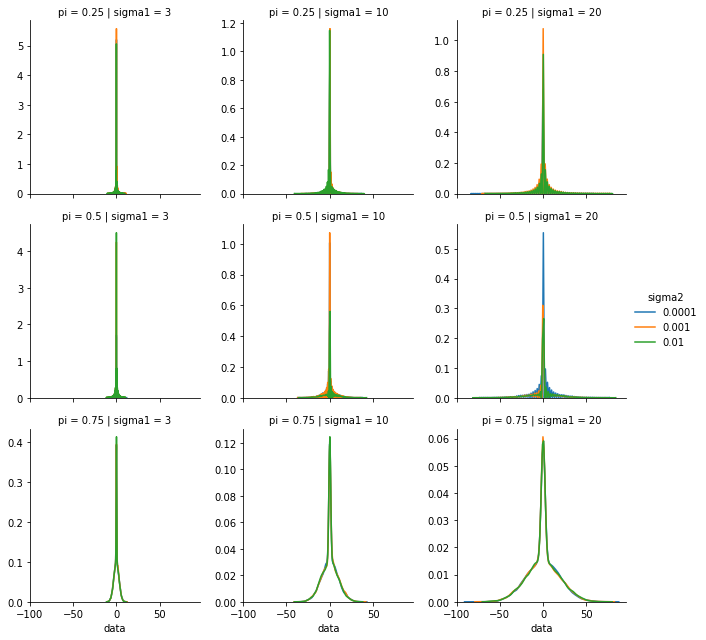

In [41]:
sigma1 = [3, 10, 20]
sigma2 = [0.0001, 0.001, 0.01]
pi = [0.25, 0.5, 0.75]
n = 10000

samples = pd.DataFrame()

for _sigma1 in sigma1:
    for _sigma2 in sigma2:
        for _pi in pi:
            n_cluster_1 = np.random.binomial(n=n, p=_pi)
            c1 = np.random.normal(scale=_sigma1, size=n_cluster_1)
            c2 = np.random.normal(scale=_sigma2, size=n-n_cluster_1)
            sample = np.append(c1, c2)
            sample_df = pd.DataFrame({'sigma1': _sigma1, 'sigma2': _sigma2, 'pi': _pi, 'data': sample})
            samples = samples.append(sample_df)

g = sns.FacetGrid(row='pi', col='sigma1', hue='sigma2', data=samples, sharey=False)
g.map(sns.distplot, 'data', hist=False).add_legend()

We see that $\sigma_1$ controls how wide the tail of the distribution is. $\pi$ controls how much mass goes into the tail distribution (the larger $\pi$, the more weight goes in the tail). With the parameter range we set up here, varying $\sigma_2$ does not have a big impact. The main point about this parameter is that it is close to zero.

There's no particular reason to choose this prior except that it is convenient to work with and puts much mass at weights near zero.

## Minibatches and KL reweighting

The authors of [1] introduce another hyperparameter that can be tuned. Note that the main point of using batch gradient descent is that it gives an unbiased estimate of the KL divergence. 

We can modify the standard batch gradient procedure to weight the complexity cost and the likelihood differently, depending on batch.

Let us make this more precise. Suppose we have split the dataset $\mathcal D$ into $M$ batches $\mathcal D_i$. Pick $M$ weights $\pi_i > 0$, such that $\sum_i \pi = 1$. Then we can give weight to the complexity cost and likelihood cost as follows:

$$
\pi_i \text{KL}(q({\bf w}\vert \theta) \Vert p({\bf w})) - \mathbb E_{q({\bf w} \vert \theta)} \left[P( {\mathbf w} \vert \mathcal D ) \right] \:.
$$

In practice this means that in step 4. of the algorithm, we multiply the first term by $\pi_i$. A schema that the authors propose to use is

$$
\pi_i = \frac{2 ^ {M - i}}{2 ^ M - 1} \:.
$$

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Complexity weight and batch number')

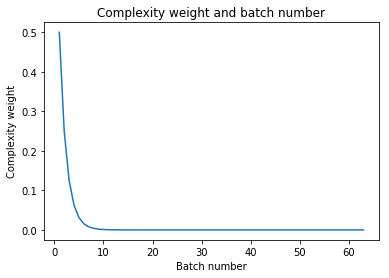

In [57]:
M = 100
_i = np.arange(1, M+1)
_y = 1 / (2 ** _i)
plt.plot(_i, _y)
plt.xlabel("Batch number")
plt.ylabel("Complexity weight")
plt.title("Complexity weight and batch number")

The idea behing this weighting scheme is that, initially, we do not want to weight the data too much as this would lead to very volatile distributions, since we've probably not inirialized the parameters very well. THe closer we get to high batch number, the more the influence of the data, when the inital conditions should not be important anymore.

# Application and Implementation

In this section, we implement the "Bayes By Backprop" algorithm in PyTorch. We then apply the algorithm to a simulated dataset and the classical MNIST dataset.

## Simulated dataset

Possibly binary classification with different best achievable accuracy in different regions.

## MNIST

Could try to extend algorithm to CNN. Should not be too hard (don't blame me for that sentence later)

## Real life dataset

(Maybe claims frequency prediction)

# Connection to ADVI

A very short time after [1] was published, the paper ["Automatic Variational Inference in Stan"](https://arxiv.org/pdf/1506.03431.pdf)[2], was published (for a good practical introduction to ADVI, see the [PyMC3 docs](https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html)). We'll briefly outline how ADVI works and show that "Bayes by Backprop" is a special case of ADVI.

# Summary

# References

+ https://gluon.mxnet.io/chapter18_variational-methods-and-uncertainty/bayes-by-backprop.html
+ 1: Blundell, Charles, et al. "Weight uncertainty in neural networks." arXiv preprint arXiv:1505.05424 (2015).https://arxiv.org/pdf/1505.05424.pdf
+ 2: Kucukelbir, Alp, et al. "Automatic variational inference in Stan." Advances in neural information processing systems. 2015.